## COVID-19 death analysis
## Author: Jun Kim
## Objective: Build a model that predicts whether a COVID-19 case results in a death or not
#### This data was obtained from the CDC and can be downloaded here: https://data.cdc.gov/Case-Surveillance/COVID-19-Case-Surveillance-Public-Use-Data-with-Ge/n8mc-b4w4.  Descriptions of the features are also listed on the site.

In [383]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pylab as plt

#### Due to the very large size of the original dataset, a sample of around 362,000 rows was used for this analysis.  The dates range from Jan 2020 to Sept 2021

#### The training set contains data from Jan 2020 to June 2021, and the test set contains data from July 2021 onwards. This results in roughly an 80%-20% split

In [384]:
# Load data
df_train = pd.read_csv('train.csv', low_memory=False)
df_test = pd.read_csv('test.csv', low_memory=False)

# Check shapes
print(df_train.shape)
print(df_test.shape)

(285316, 19)
(76935, 19)


## Data Wrangling and preparation
#### This data has a lot of missing data.  Almost every row has at least one missing value, so simply removing those rows is not an option.  This is the methodology I used to impute missing data:
#### For variables with many different categories (ex. Race), a catch-all bucket named "Missing" was created for all missing/unknown values.
#### For binary variables that indicated the presense of something (ex. Hospitalized or not), missing values were assumed to be 0.
#### For numerical variables, missing values were imputed with their average values

In [385]:
# Drop variables
# - state_fips_code is already reflected in the state
# - There are 1,350 distinct county_fips_code values and 938 distinct res_county values
#   This would blow up the feature input space way too much, and likely doesn't carry meaningful information
df_train.drop(['state_fips_code', 'res_county', 'county_fips_code'], axis=1, inplace=True)
df_test.drop(['state_fips_code', 'res_county', 'county_fips_code'], axis=1, inplace=True)

# Calculate averages for numerical values
psi_train_avg = df_train['case_positive_specimen_interval'].mean()
oi_train_avg = df_train['case_onset_interval'].mean()

psi_test_avg = df_test['case_positive_specimen_interval'].mean()
oi_test_avg = df_test['case_onset_interval'].mean()

# Fill missing values for training set
df_train.replace({'age_group':{np.nan:'Missing'}}, inplace=True)
df_train.replace({'sex':{np.nan:'Missing', 'Unknown':'Missing'}}, inplace=True)
df_train.replace({'race':{np.nan:'Missing', 'Unknown':'Missing'}}, inplace=True)
df_train.replace({'ethnicity':{np.nan:'Missing', 'Unknown':'Missing'}}, inplace=True)
df_train.replace({'case_positive_specimen_interval':{np.nan:psi_train_avg}}, inplace=True)
df_train.replace({'case_onset_interval':{np.nan:oi_train_avg}}, inplace=True)
df_train.replace({'process':{np.nan:'Missing', 'Unknown':'Missing', 'Other detection method (specify)':'Missing', 'Other':'Missing'}}, inplace=True)
df_train.replace({'exposure_yn':{np.nan:0}}, inplace=True)
df_train.replace({'symptomatic_yn':{np.nan:0}}, inplace=True)
df_train.replace({'hosp_yn':{np.nan:0}}, inplace=True)
df_train.replace({'icu_yn':{np.nan:0}}, inplace=True)
df_train.replace({'underlying_conditions_yn':{np.nan:0}}, inplace=True)
df_train.replace({'labconfirmed_yn':{np.nan:0}}, inplace=True)
df_train.replace({'death_yn':{np.nan:0}}, inplace=True)

# Fill missing values for test set
df_test.replace({'death_yn':{np.nan:0}}, inplace=True)
df_test.replace({'age_group':{np.nan:'Missing'}}, inplace=True)
df_test.replace({'sex':{np.nan:'Missing', 'Unknown':'Missing'}}, inplace=True)
df_test.replace({'race':{np.nan:'Missing', 'Unknown':'Missing'}}, inplace=True)
df_test.replace({'ethnicity':{np.nan:'Missing', 'Unknown':'Missing'}}, inplace=True)
df_test.replace({'case_positive_specimen_interval':{np.nan:psi_test_avg}}, inplace=True)
df_test.replace({'case_onset_interval':{np.nan:oi_test_avg}}, inplace=True)
df_test.replace({'process':{np.nan:'Missing', 'Unknown':'Missing', 'Other detection method (specify)':'Missing', 'Other':'Missing'}}, inplace=True)
df_test.replace({'exposure_yn':{np.nan:0}}, inplace=True)
df_test.replace({'symptomatic_yn':{np.nan:0, 'nul':0}}, inplace=True)
df_test['symptomatic_yn'] = pd.to_numeric(df_test['symptomatic_yn'])
df_test.replace({'hosp_yn':{np.nan:0}}, inplace=True)
df_test.replace({'icu_yn':{np.nan:0, 'nul':0}}, inplace=True)
df_test['icu_yn'] = pd.to_numeric(df_test['icu_yn'])
df_test.replace({'underlying_conditions_yn':{np.nan:0}}, inplace=True)

# Check shapes
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (285316, 16)
Test shape: (76935, 16)


In [386]:
# One-hot encode categorical variables
# Also keep track of the new column names
columns = []

# Encode state
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(df_train[['res_state']])
state_train = enc.transform(df_train[['res_state']])
state_test = enc.transform(df_test[['res_state']])
for i in np.array(enc.categories_).flatten():
    columns.append(i)
    
# Encode age group
enc.fit(df_train[['age_group']])
age_train = enc.transform(df_train[['age_group']])
age_test = enc.transform(df_test[['age_group']])
for i in np.array(enc.categories_).flatten():
    columns.append(i)

# Encode sex
enc.fit(df_train[['sex']])
sex_train = enc.transform(df_train[['sex']])
sex_test = enc.transform(df_test[['sex']])
for i in np.array(enc.categories_).flatten():
    columns.append(i)

# Encode race
enc.fit(df_train[['race']])
race_train = enc.transform(df_train[['race']])
race_test = enc.transform(df_test[['race']])
for i in np.array(enc.categories_).flatten():
    columns.append(i)

# Encode ethnicity
enc.fit(df_train[['ethnicity']])
ethnicity_train = enc.transform(df_train[['ethnicity']])
ethnicity_test = enc.transform(df_test[['ethnicity']])
for i in np.array(enc.categories_).flatten():
    columns.append(i)

# Encode process
enc.fit(df_train[['process']])
process_train = enc.transform(df_train[['process']])
process_test = enc.transform(df_test[['process']])
for i in np.array(enc.categories_).flatten():
    columns.append(i)

In [387]:
# Represent case_month as the number of months since Jan 2020

# Since Covid-19 has mutated and we have seen many different variants, it is expected that death rates
#   may vary depending on what variant was prevalent at the time.  Keeping the month as a variable
#   can take this into account and give heavier weight to more recent examples

month_train = (pd.to_datetime(df_train['case_month']).dt.year - 2020) * 12 + \
               pd.to_datetime(df_train['case_month']).dt.month
month_train = month_train.to_frame()

month_test = (pd.to_datetime(df_test['case_month']).dt.year - 2020) * 12 + \
               pd.to_datetime(df_test['case_month']).dt.month
month_test = month_test.to_frame()

In [388]:
# Normalize numerical variables

# Since most of our variables are categorical and are in the range of 0-1, I thought it would be 
#   more appropriate to have numerical variables also within 0-1, hence the MinMaxScaler
#   as opposed to the StandardScaler.
scaler = MinMaxScaler()

# Normalize month
month_train_scaled = scaler.fit_transform(month_train)
month_test_scaled = scaler.transform(month_test)
columns.append('Month')

# Normalize case_positive_specimen_interval
case_PSI_train_scaled = scaler.fit_transform(df_train[["case_positive_specimen_interval"]])
case_PSI_test_scaled = scaler.transform(df_test[["case_positive_specimen_interval"]])
columns.append('Case_PSI')
                                     
# Normalize case_onset_interval
case_OI_train_scaled = scaler.fit_transform(df_train[["case_onset_interval"]])
case_OI_test_scaled = scaler.transform(df_test[["case_onset_interval"]])
columns.append('Case_OI')

In [389]:
# Concatenate into the final dataset in the order that the column names were added

# Training set
y = df_train['death_yn']
df_train.drop(['case_month', 'res_state', 'age_group', 'sex', 'race', 'ethnicity', 'process', 'death_yn', \
                  'case_positive_specimen_interval', 'case_onset_interval'], axis=1, inplace=True)
X = np.concatenate([state_train, age_train, sex_train, race_train, ethnicity_train, process_train, \
                    month_train_scaled, case_PSI_train_scaled, case_OI_train_scaled, df_train], axis=1)

# Test set
y_test = df_test['death_yn']
df_test.drop(['case_month', 'res_state', 'age_group', 'sex', 'race', 'ethnicity', 'process', 'death_yn', \
                  'case_positive_specimen_interval', 'case_onset_interval'], axis=1, inplace=True)
X_test = np.concatenate([state_test, age_test, sex_test, race_test, ethnicity_test, process_test, \
                        month_test_scaled, case_PSI_test_scaled, case_OI_test_scaled, df_test], axis=1)

# Add remaining feature names to columns list
for i in df_train.columns:
    columns.append(i)

# Check shapes
print("X train shape:", X.shape)
print("y train shape:", y.shape)
print("X test shape:", X_test.shape)
print("y test shape:", y_test.shape)

X train shape: (285316, 89)
y train shape: (285316,)
X test shape: (76935, 89)
y test shape: (76935,)


#### After testing many different classification models, Logistic Regression ended up being one of the top performing models

In [390]:
# Hyperparameter grid search with cross validation - this step can take a few minutes
for i in np.arange(0.2, 2.1, 0.2):
    logreg = LogisticRegression(max_iter=300)
    scores = cross_val_score(logreg, X, y, cv=5)
    print(f"C = {i}: {np.mean(scores):.4f}")

C = 0.2: 0.9824
C = 0.4: 0.9824
C = 0.6000000000000001: 0.9824
C = 0.8: 0.9824
C = 1.0: 0.9824
C = 1.2: 0.9824
C = 1.4000000000000001: 0.9824
C = 1.6: 0.9824
C = 1.8: 0.9824
C = 2.0: 0.9824


Test score: 0.9954
Test AUC: 0.9668


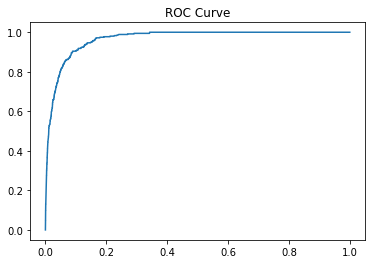

In [391]:
# Seems like the hyperparameter choice doesn't make much of a difference. Let's stick to the default.
# Evaluate our final model on the basis of accuracy, ROC, and AUC

logreg = LogisticRegression(max_iter=300)
logreg.fit(X, y)
score = logreg.score(X_test, y_test)
pred = logreg.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, pred)

print(f"Test score: {score:.4f}")
print(f"Test AUC: {auc:.4f}")

fpr, tpr, thresh = roc_curve(y_test, pred)
plt.title("ROC Curve")
plt.plot(fpr, tpr)

Top Ten Features:

65+ years. Coefficient: 3.31
PR. Coefficient: 3.30
0 - 17 years. Coefficient: -2.72
Month. Coefficient: -2.38
18 to 49 years. Coefficient: -1.93
hosp_yn. Coefficient: 1.79
Case_PSI. Coefficient: -1.64
GA. Coefficient: -1.59
NE. Coefficient: -1.47
icu_yn. Coefficient: 1.45


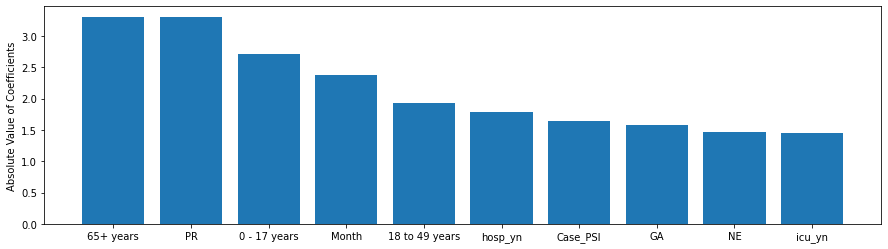

In [392]:
# Most significant variables

coefs = logreg.coef_.flatten()
columns = np.array(columns)

abs_coefs = np.abs(coefs)
sign_coefs = np.sign(coefs)
indexes = np.flip(np.argsort(abs_coefs))

top_ten_features = columns[indexes][:10]
top_ten_magnitude = abs_coefs[indexes][:10]
top_ten_sign = sign_coefs[indexes][:10]

# Plot
plt.figure(figsize=(15,4))
plt.bar(top_ten_features, top_ten_magnitude)
plt.ylabel("Absolute Value of Coefficients")

print("Top Ten Features:\n")
for i in range(len(top_ten_features)):
    print(f'{top_ten_features[i]}. Coefficient: {top_ten_magnitude[i] * top_ten_sign[i]:.2f}')
    

### Thank you for checking out my model and analysis! Hope you liked it!